In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor

In [3]:
biomes = [1,2,3,4,5,6,7,8]

In [4]:
# calbiomeDictLAI = pd.read_pickle('G:/cassidy/MODISLANDSAT_py37/calbiomeDictLAI.pkl')
biomeDictLAI = dict()
for i in biomes:
    biomeDictLAI[i] = dict()
    biomeDictLAI[i]['valDF'] = pd.read_csv('G:/cassidy/MODISLANDSAT_py37/valbiomeDictLAIbiome' + str(i) + '.csv')
    biomeDictLAI[i]['calDF'] = pd.read_csv('G:/cassidy/MODISLANDSAT_py37/calbiomeDictLAIbiome' + str(i) + '.csv')

In [5]:
regressors = ['red','NIR','cosSZA','cosVZA','cosSA']
response = 'LAI'

for i in biomes:
    dfcal = biomeDictLAI[i]['calDF'].sample(10000)
    dfval = biomeDictLAI[i]['valDF'].sample(100)

    biomeDictLAI[i]['X_train'] = dfcal[regressors]
    biomeDictLAI[i]['y_train'] = dfcal[response]

    biomeDictLAI[i]['X_test'] = dfval[regressors]
    biomeDictLAI[i]['y_test'] = dfval[response]

In [6]:
for i in biomes:
    biomeDictLAI[i]['rf'] = RandomForestRegressor(n_estimators=100,min_samples_leaf=10,max_features=5,bootstrap=True,random_state=0,verbose=0,n_jobs=-1,max_leaf_nodes=10000)
    biomeDictLAI[i]['rf'].fit(biomeDictLAI[i]['X_train'], biomeDictLAI[i]['y_train'])

## Scikit-garden

In [7]:
from skgarden import RandomForestQuantileRegressor

In [8]:
for i in biomes:
    biomeDictLAI[i]['rfqr'] = RandomForestQuantileRegressor(n_estimators=100,min_samples_leaf=10,max_features=5,bootstrap=True,random_state=0,verbose=0,n_jobs=-1,max_leaf_nodes=10000)

In [9]:
print(biomeDictLAI[1]['rfqr'])

RandomForestQuantileRegressor(bootstrap=True, criterion='mse', max_depth=None,
                              max_features=5, max_leaf_nodes=10000,
                              min_samples_leaf=10, min_samples_split=2,
                              min_weight_fraction_leaf=0.0, n_estimators=100,
                              n_jobs=-1, oob_score=False, random_state=0,
                              verbose=0, warm_start=False)


In [10]:
y_true_all = []
lower = []
upper = []

for i in biomes:
    biomeDictLAI[i]['rfqr'].set_params(max_features=biomeDictLAI[i]['X_train'].shape[1] // 3)
    biomeDictLAI[i]['rfqr'].fit(biomeDictLAI[i]['X_train'], biomeDictLAI[i]['y_train'])
    biomeDictLAI[i]['upper'] = biomeDictLAI[i]['rfqr'].predict(biomeDictLAI[i]['X_test'], quantile=98.5)
    biomeDictLAI[i]['lower'] = biomeDictLAI[i]['rfqr'].predict(biomeDictLAI[i]['X_test'], quantile=2.5)
    biomeDictLAI[i]['mid'] = biomeDictLAI[i]['rfqr'].predict(biomeDictLAI[i]['X_test'], quantile=50)

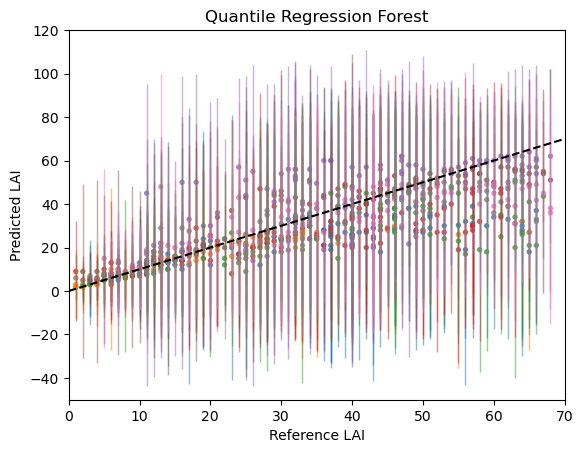

In [11]:
axes = []
for i in biomes:
    plt.errorbar(biomeDictLAI[i]['y_test'], biomeDictLAI[i]['mid'], yerr=np.subtract(biomeDictLAI[i]['upper'], biomeDictLAI[i]['lower']), alpha=0.5, ls='None', lw=1)
    axes.append(plt.scatter(biomeDictLAI[i]['y_test'], biomeDictLAI[i]['mid'], s=15, alpha=0.8, edgecolors='none', label=str(i)))
plt.plot([0, 70], [0, 70], 'k--')
plt.xlabel("Reference LAI")
plt.ylabel("Predicted LAI")
plt.title('Quantile Regression Forest')
plt.xlim([0, 70])
plt.ylim([-50, 120])
# plt.legend(handles=axes, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

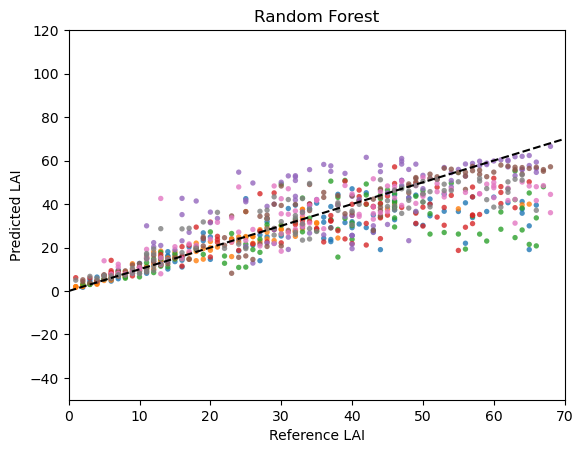

In [23]:
axes = []
for i in biomes:
    biomeDictLAI[i]['y_hat'] = biomeDictLAI[i]['rf'].predict(biomeDictLAI[i]['X_test'])
    axes.append(plt.scatter(biomeDictLAI[i]['y_test'], biomeDictLAI[i]['y_hat'], s=15, alpha=0.8, edgecolors='none', label=str(i)))
plt.plot([0, 70], [0, 70], 'k--')
plt.xlabel("Reference LAI")
plt.ylabel("Predicted LAI")
plt.title('Random Forest')
plt.xlim([0, 70])
plt.ylim([-50, 120])
# plt.legend(handles=axes, loc='center left', bbox_to_anchor=(1, 0.5), title='Biome')
plt.show()

## TensorFlow

In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [14]:
np.shape(np.array(biomeDictLAI[i]['X_train']))

(10000, 5)

In [15]:
for i in biomes:
    normalizer = layers.Normalization(input_shape=[5,], axis=None)
    normalizer.adapt(np.array(biomeDictLAI[i]['X_train']))
    
    biomeDictLAI[i]['model'] = tf.keras.Sequential([
        normalizer,
        layers.Dense(50, activation='relu'),
        layers.Dense(10, activation='relu'),
        layers.Dense(1)])

In [16]:
for i in biomes:
    biomeDictLAI[i]['model'].compile(optimizer='adam',
                  loss='mean_absolute_error',
                  metrics=['mean_squared_error'])

In [17]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') is not None and logs.get('accuracy') > 0.99:                 
            print("\nReached 99% accuracy so cancelling training!")
            self.model.stop_training = True

In [18]:
for i in biomes:
    callbacks = myCallback()
    biomeDictLAI[i]['history'] = biomeDictLAI[i]['model'].fit(biomeDictLAI[i]['X_train'].to_numpy(), biomeDictLAI[i]['y_train'].to_numpy(), epochs=100, validation_split=0.2, verbose=0, callbacks=[callbacks])
    biomeDictLAI[i]['y_nn'] = biomeDictLAI[i]['model'].predict(biomeDictLAI[i]['X_test'])

4/4 [==============================] - 0s 2ms/step


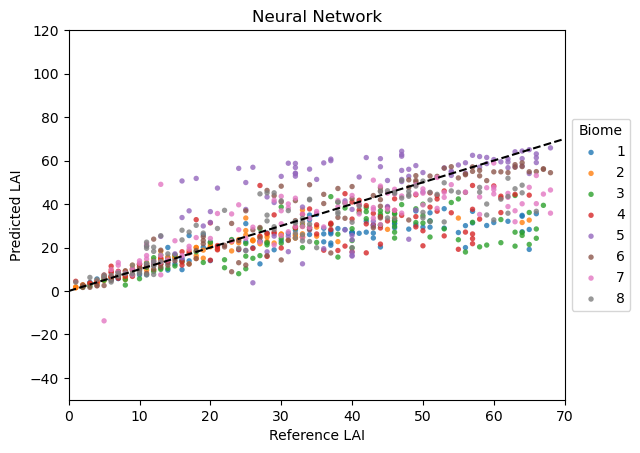

In [19]:
axes = []
for i in biomes:
    axes.append(plt.scatter(biomeDictLAI[i]['y_test'], biomeDictLAI[i]['y_nn'], s=15, alpha=0.8, edgecolors='none', label=str(i)))
plt.plot([0, 70], [0, 70], 'k--')
plt.xlabel("Reference LAI")
plt.ylabel("Predicted LAI")
plt.title('Neural Network')
plt.xlim([0, 70])
plt.ylim([-50, 120])
plt.legend(handles=axes, loc='center left', bbox_to_anchor=(1, 0.5), title='Biome')
plt.show()

In [20]:
biomeDictLAI[2]['model'].summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 5)                3         
 ion)                                                            
                                                                 
 dense_3 (Dense)             (None, 50)                300       
                                                                 
 dense_4 (Dense)             (None, 10)                510       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 824
Trainable params: 821
Non-trainable params: 3
_________________________________________________________________


In [21]:
i = 5
biomeDictLAI[i]['model'].evaluate(biomeDictLAI[i]['X_test'],  biomeDictLAI[i]['y_test'], verbose=2)

4/4 - 0s - loss: 11.3796 - mean_squared_error: 214.5026 - 192ms/epoch - 48ms/step


[11.379633903503418, 214.50262451171875]

In [22]:
len(biomeDictLAI[2]['history'].epoch)

100

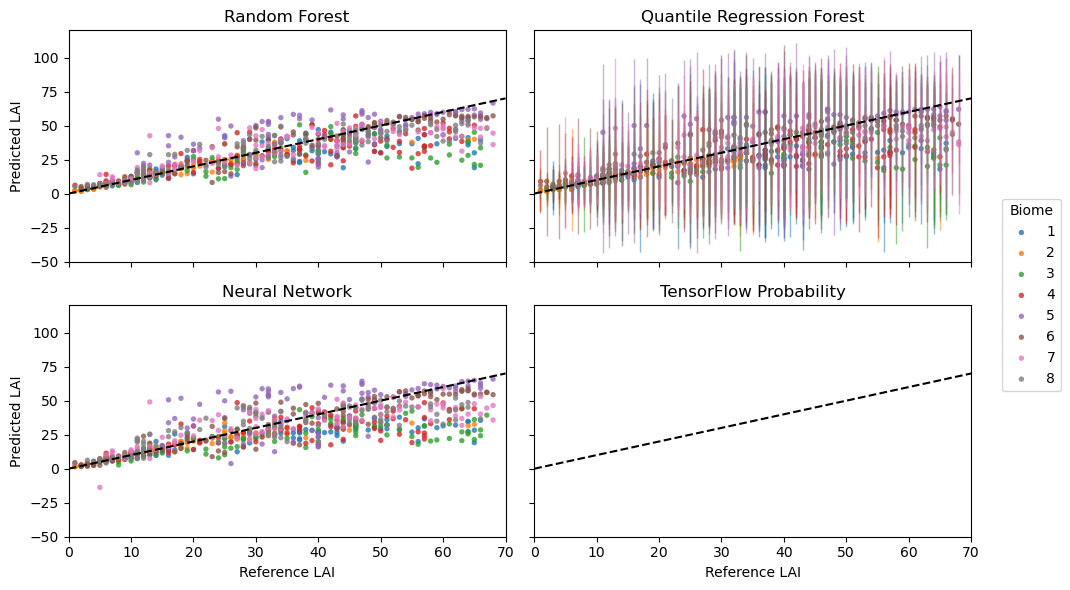

In [67]:
temp = []
fig, axes = plt.subplots(nrows=2, ncols=2, sharey=True, sharex=True, figsize=(10,6))
for i in biomes:
    axes[0,1].errorbar(biomeDictLAI[i]['y_test'], biomeDictLAI[i]['mid'], yerr=np.subtract(biomeDictLAI[i]['upper'], biomeDictLAI[i]['lower']), alpha=0.5, ls='None', lw=1)
    axes[0,1].scatter(biomeDictLAI[i]['y_test'], biomeDictLAI[i]['mid'], s=15, alpha=0.8, edgecolors='none', label=str(i))
    axes[0,0].scatter(biomeDictLAI[i]['y_test'], biomeDictLAI[i]['y_hat'], s=15, alpha=0.8, edgecolors='none', label=str(i))
    temp.append(axes[1,0].scatter(biomeDictLAI[i]['y_test'], biomeDictLAI[i]['y_nn'], s=15, alpha=0.8, edgecolors='none', label=str(i)))

for axs in axes:
    for ax in axs:
        ax.plot([0, 70], [0, 70], 'k--')
        ax.set_xlim([0, 70])
        ax.set_ylim([-50, 120])
    
axes[0,0].set_ylabel("Predicted LAI")
axes[1,0].set_ylabel("Predicted LAI")
axes[1,0].set_xlabel("Reference LAI")
axes[1,1].set_xlabel("Reference LAI")
axes[0,1].set_title('Quantile Regression Forest')
axes[0,0].set_title('Random Forest')
axes[1,0].set_title('Neural Network')
axes[1,1].set_title('TensorFlow Probability')
fig.tight_layout()
fig.legend(handles=temp, loc='center left', bbox_to_anchor=(1, 0.5), title='Biome')